In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely import geometry
import libpysal

In [2]:
# CONSTANTS
CRS_PROJ = "EPSG:3414"  # Singapore SVY21
DISTANCE_THRESHOLD = 1600  # 1.5km max walking distance (~20 mins)

# 1. Load Singapore Network (Walk)
# Note: This might take a while. For testing, use a smaller area like "Tampines, Singapore"
place_name = "Singapore"
network_type = "walk"
G = ox.graph_from_place(place_name, network_type=network_type)

# Project Graph to Meters (Critical for distance calc)
G_proj = ox.project_graph(G, to_crs=CRS_PROJ)

In [3]:
raw_path = "../data/data_raw/"

In [4]:
hdb_population = 3190590
hdb_unit_num = 1153080

planning_area = gpd.read_file(f"{raw_path}MasterPlan2019PlanningAreaBoundaryNoSea.geojson")
subzone = gpd.read_file(f"{raw_path}MasterPlan2019SubzoneBoundaryNoSeaGEOJSON.geojson")
sport_facilities  = gpd.read_file(f"{raw_path}SportSGSportFacilitiesGEOJSON.geojson")
parks = gpd.read_file(f"{raw_path}NParksParksandNatureReserves.geojson")
park_connector = gpd.read_file(f"{raw_path}ParkConnectorLoop.geojson")
cycling_paths = gpd.read_file(f"{raw_path}CyclingPathNetwork.geojson")
hdb = gpd.read_file(f"{raw_path}HDBExistingBuilding.geojson")

In [5]:
planning_area = planning_area.to_crs(CRS_PROJ)
subzone = subzone.to_crs(CRS_PROJ)
sport_facilities = sport_facilities.to_crs(CRS_PROJ)
park_connector = park_connector.to_crs(CRS_PROJ)
parks = parks.to_crs(CRS_PROJ)
cycling_paths = cycling_paths.to_crs(CRS_PROJ)
hdb = hdb.to_crs(CRS_PROJ)

In [6]:
# Count number of HDB buildings
hdb_num = len(hdb)
hdb_population_per_block = hdb_population / hdb_num
hdb_population_per_unit = hdb_population / hdb_unit_num

print(f"Number of HDB buildings: {hdb_num}")
print(f"Rough estimation of population per HDB block: {hdb_population_per_block}")
print(f"Number of HDB units: {hdb_unit_num}")
print(f"Rough estimation of population per HDB unit: {hdb_population_per_unit}")

Number of HDB buildings: 13160
Rough estimation of population per HDB block: 242.44604863221883
Number of HDB units: 1153080
Rough estimation of population per HDB unit: 2.7670152981579768


In [7]:
# Add population column to HDB geodataframe (per-block estimate)
hdb['population'] = hdb_population_per_block
hdb.head()

,name,geometry,population
0,Path,"LINESTRING (24481.043 47869.63, 24480.427 4786...",242.446049
1,Path,"LINESTRING (18753.211 37893.756, 18764.786 379...",242.446049
2,Path,"LINESTRING (41887.998 37282.122, 41889.532 372...",242.446049
3,Path,"LINESTRING (18696.214 41806.326, 18691.537 418...",242.446049
4,Path,"LINESTRING (26218.761 29036.217, 26222.34 2904...",242.446049


In [8]:
def facility_preprocessing(gdf_facilities):
    """
    Prepares SportSG Facilities Data.
    """
    # Ensure CRS
    gdf_facilities = gdf_facilities.to_crs(CRS_PROJ)
    
    # Change the geometry from polygon Z to point (centroid )
    gdf_facilities['geometry'] = gdf_facilities.geometry.centroid
    
    # Assign ID
    gdf_facilities['facility_id'] = range(len(gdf_facilities))
    
    # Ensure we have a capacity column (Supply). 
    # Since floor area is not available, we'll assume 1
    if 'capacity' not in gdf_facilities.columns:
        gdf_facilities['capacity'] = 1
        
    return gdf_facilities

In [9]:
def population_preprocessing(gdf_pop):
    """
    Prepares HDB Population Data.
    """
    # Ensure CRS
    gdf_pop = gdf_pop.to_crs(CRS_PROJ)
    
    # Ensure we have centroids
    gdf_pop['centroid'] = gdf_pop.geometry.centroid
    
    # Assign ID
    gdf_pop['pop_id'] = range(len(gdf_pop))
    
    # Create a buffer for the "Euclidean Filter" step later
    gdf_pop['search_buffer'] = gdf_pop['centroid'].buffer(DISTANCE_THRESHOLD)
    
    return gdf_pop

In [10]:
def get_network_distances(gdf_pop, gdf_facilities, G_proj):
    """
    Calculates network distance between Pop and Facilities
    ONLY if they are within the Euclidean buffer (Optimization).
    """
    
    # 1. Pre-filter: Find pairs that are geographically close (Vectorized)
    # This prevents calculating network paths for Punggol -> Jurong (waste of time)
    joined = gpd.sjoin(
        gdf_facilities, 
        gpd.GeoDataFrame(gdf_pop[['pop_id', 'search_buffer']], geometry='search_buffer'), 
        how='inner', 
        predicate='within'
    )
    
    # 2. Get Nearest Network Nodes
    # To speed this up, calculating nodes for unique points only
    
    # For Population
    pop_nodes = ox.nearest_nodes(G_proj, gdf_pop.centroid.x, gdf_pop.centroid.y)
    gdf_pop['origin_node'] = pop_nodes
    
    # For Facilities
    fac_nodes = ox.nearest_nodes(G_proj, gdf_facilities.geometry.x, gdf_facilities.geometry.y)
    gdf_facilities['dest_node'] = fac_nodes
                
    # Merge Node IDs into the pair list
    pairs = joined.merge(gdf_pop[['pop_id', 'origin_node', 'population']], on='pop_id', how='left')
    pairs = pairs.merge(
        gdf_facilities[['facility_id', 'dest_node', 'capacity']],
        on='facility_id',
        how='left',
        suffixes=("_x", "_y")
    )

    # Normalize column names to avoid dest_node_x/dest_node_y conflicts
    if 'dest_node' not in pairs.columns:
        if 'dest_node_y' in pairs.columns:
            pairs.rename(columns={'dest_node_y': 'dest_node'}, inplace=True)
        elif 'dest_node_x' in pairs.columns:
            pairs.rename(columns={'dest_node_x': 'dest_node'}, inplace=True)
    if 'capacity' not in pairs.columns:
        if 'capacity_y' in pairs.columns:
            pairs.rename(columns={'capacity_y': 'capacity'}, inplace=True)
        elif 'capacity_x' in pairs.columns:
            pairs.rename(columns={'capacity_x': 'capacity'}, inplace=True)

    # 3. Calculate Shortest Path (The Heavy Lifting)
    # Using NetworkX bi-directional dijkstra (fastest for 1-to-1)
    results = []
    
    for idx, row in pairs.iterrows():
        try:
            dist = nx.shortest_path_length(
                G_proj, 
                source=row['origin_node'], 
                target=row['dest_node'], 
                weight='length'
            )
            
            # Only keep if within threshold
            if dist <= DISTANCE_THRESHOLD:
                results.append({
                    'pop_id': row['pop_id'],
                    'facility_id': row['facility_id'],
                    'distance': dist,
                    'pop_demand': row['population'],
                    'facility_supply': row['capacity']
                })
        except nx.NetworkXNoPath:
            continue
            
    return pd.DataFrame(results)

In [11]:
def calculate_m2sfca(df_od, distance_threshold):
    """
    Calculate accessibility scores
    """
    
    # --- Gaussian Decay Function ---
    # As distance increases, weight drops.
    # At 0m, weight = 1. At Threshold, weight approaches 0.
    v = -distance_threshold**2 / np.log(0.01) # 0.01 is the weight at the limit
    df_od['weight'] = np.exp(-(df_od['distance'])**2 / v)
    
    # --- Step 1: Supply-to-Demand Ratio (Rj) ---
    # How crowded is the facility?
    
    # Weighted Demand: Pop * DistanceWeight
    df_od['weighted_demand'] = df_od['pop_demand'] * df_od['weight']
    
    # Sum of weighted demand per Facility
    facility_demand_sum = df_od.groupby('facility_id')['weighted_demand'].sum().reset_index()
    facility_demand_sum.rename(columns={'weighted_demand': 'total_demand_at_facility'}, inplace=True)
    
    # Merge back
    df_od = df_od.merge(facility_demand_sum, on='facility_id')
    
    # Calculate Ratio Rj = Supply / Total Weighted Demand
    df_od['Rj'] = df_od['facility_supply'] / df_od['total_demand_at_facility']
    
    # --- Step 2: Accessibility Score (Ai) ---
    # Sum the ratios available to each resident
    
    # Weighted Ratio: Rj * DistanceWeight
    df_od['weighted_Rj'] = df_od['Rj'] * df_od['weight']
    
    # Sum per Population Point
    accessibility_scores = df_od.groupby('pop_id')['weighted_Rj'].sum().reset_index()
    accessibility_scores.rename(columns={'weighted_Rj': '2sfca_score'}, inplace=True)
    
    return accessibility_scores

In [12]:
# 2. Preprocess
hdb = population_preprocessing(hdb)
sport_facilities = facility_preprocessing(sport_facilities)

In [13]:
hdb.head()

,name,geometry,population,centroid,pop_id,search_buffer
0,Path,"LINESTRING (24481.043 47869.63, 24480.427 4786...",242.446049,POINT (24457.667 47865.143),0,"POLYGON ((25957.667 47865.143, 25950.444 47718..."
1,Path,"LINESTRING (18753.211 37893.756, 18764.786 379...",242.446049,POINT (18772.678 37887.871),1,"POLYGON ((20272.678 37887.871, 20265.455 37740..."
2,Path,"LINESTRING (41887.998 37282.122, 41889.532 372...",242.446049,POINT (41907.212 37272.926),2,"POLYGON ((43407.212 37272.926, 43399.989 37125..."
3,Path,"LINESTRING (18696.214 41806.326, 18691.537 418...",242.446049,POINT (18723.768 41826.052),3,"POLYGON ((20223.768 41826.052, 20216.545 41679..."
4,Path,"LINESTRING (26218.761 29036.217, 26222.34 2904...",242.446049,POINT (26245.512 29051.375),4,"POLYGON ((27745.512 29051.375, 27738.289 28904..."


In [14]:
sport_facilities.head()

,Name,Description,geometry,facility_id,capacity
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT (20450.387 32532.653),1,1
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT (12544.661 35609.322),2,1
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT (32351.913 33877.383),3,1
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT (33033.718 32012.926),4,1


In [15]:
# 3. Calculate Network Distances (The Slow Part)
df_od_pairs = get_network_distances(hdb, sport_facilities, G_proj)

In [16]:
# 4. Compute Score
final_scores = calculate_m2sfca(df_od_pairs, DISTANCE_THRESHOLD)

<Axes: >

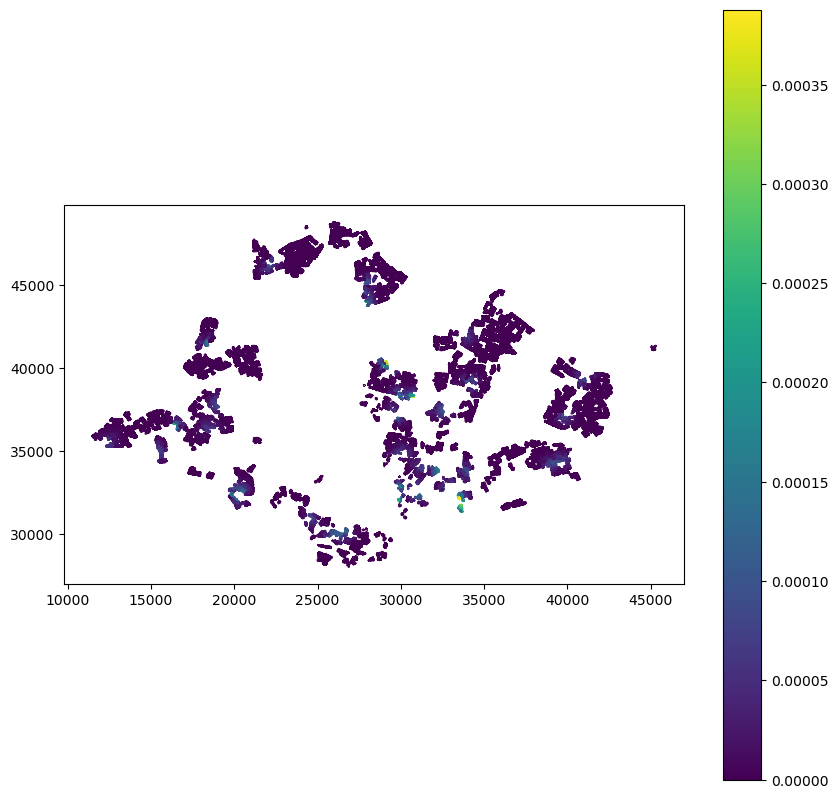

In [17]:
# 5. Merge back to Map
final_map = hdb.merge(final_scores, on='pop_id', how='left')

# Fill NaN with 0 (areas with NO access)
final_map['2sfca_score'] = final_map['2sfca_score'].fillna(0)


# 6. Visualize
final_map.plot(column='2sfca_score', legend=True, cmap='viridis', figsize=(10, 10))

In [21]:
# 7. Export GeoDataFrame to GeoJSON (WGS84)
from pathlib import Path

# Prepare a copy with only one geometry column
final_map_export = final_map.copy()
active_geom_name = final_map_export.geometry.name
extra_geom_cols = [c for c, dt in final_map_export.dtypes.items() if dt == "geometry" and c != active_geom_name]
if extra_geom_cols:
    final_map_export = final_map_export.drop(columns=extra_geom_cols)

# Reproject to WGS84 for GeoJSON/web mapping
# GeoJSON (RFC 7946) requires WGS84 coordinates (EPSG:4326) in degrees; other CRSs are not allowed in the spec.
# Web compatibility: Web map libraries (Leaflet, Mapbox GL, deck.gl) expect lon/lat GeoJSON; EPSG:3414 will render in the wrong place or be rejected
final_map_wgs84 = final_map_export.to_crs("EPSG:4326")

# Define output path
output_path = "../data/data_cleaned/final_map_2sfca.geojson"
Path(Path(output_path).parent).mkdir(parents=True, exist_ok=True)

# Save to GeoJSON
final_map_wgs84.to_file(output_path, driver="GeoJSON")
print(f"GeoJSON saved to: {output_path}")

GeoJSON saved to: ../data/data_cleaned/final_map_2sfca.geojson


In [22]:
from geopandas import GeoDataFrame

def parks_preprocessing(gdf_parks):
    """
    Prepare Parks polygons for network-based accessibility:
    - Ensure projected CRS (meters)
    - Validate/fix geometries and keep valid areas
    - Compute area (sqm, ha) as a proxy for supply
    - Convert to point geometry (centroid) for network node matching
    - Add `facility_id` and `capacity` compatible with get_network_distances()
    """
    # Copy and ensure CRS
    gdf_parks = gdf_parks.copy()
    gdf_parks = gdf_parks.to_crs(CRS_PROJ)

    # Drop empties and fix invalid geometries (buffer(0) trick)
    gdf_parks = gdf_parks[gdf_parks.geometry.notna() & ~gdf_parks.geometry.is_empty]
    gdf_parks["geometry"] = gdf_parks.buffer(0)

    # Keep polygonal geometries only
    gdf_parks = gdf_parks[gdf_parks.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]

    # Compute area in sqm and ha (projected CRS ensures meters)
    gdf_parks["area_sqm"] = gdf_parks.geometry.area
    gdf_parks = gdf_parks[gdf_parks["area_sqm"] > 0]
    gdf_parks["area_ha"] = gdf_parks["area_sqm"] / 10000.0

    # Convert to centroid for point-based network snapping
    gdf_parks["geometry"] = gdf_parks.geometry.centroid

    # IDs and capacity (area-based proxy). Clip to avoid zeros.
    gdf_parks["facility_id"] = range(len(gdf_parks))
    gdf_parks["capacity"] = gdf_parks["area_ha"].clip(lower=0.1)

    return gdf_parks